In [1]:
# Imports

import torch
import torch.nn.functional as func
from torch.autograd import Variable
from torchvision import transforms
import math
import warnings
import numpy as np
from matplotlib import pyplot as plt, patches as mpatches, cm
from IPython import display

import class_transition_model
import autoencoder
from offloading_dataloader import Dataloader, plot_example

class_transition_model_path = '../networks/transition_model_small.pth'
class_autoencoder_path = '../networks/autoencoder_h32.pth'

In [2]:
# Helper functions
def to_image(img):
    img = 0.5 * (img + 1)
    img = img.clamp(0, 1)
    img = (img.view(img.shape[-2], img.shape[-1])).detach().numpy()
    return img

def normalize_image(img):
    img = img / 255
    img = transforms.Normalize((0.5, ), (0.5, ))(img)
    return img

def show_img(img, lbl):
    img = (img.view(img.shape[-2], img.shape[-1])).detach().numpy()
    plt.imshow(img, cmap=cm.gray_r)
    plt.title(lbl)
    plt.xticks([])
    plt.yticks([])
    plt.show()

def transform_image(image, action):
    def transformation_matrix(scale=1, rotation=0):
        # scale
        T_scale = torch.Tensor([[scale+1e-8, 0, 0],
                                [0, scale+1e-8, 0],
                                [0, 0, 1]]).type(dtype)
        # rotation
        T_rot = torch.Tensor([[torch.cos(rotation), -torch.sin(rotation), 0],
                              [torch.sin(rotation), torch.cos(rotation), 0],
                              [0, 0, 1]]).type(dtype)

        # combine matrices
        T = T_rot @ T_scale
        T_inv = torch.linalg.inv(T).type(dtype)
        return T_inv[0:2, :]

    if not image.size() == torch.zeros(size=[1, 1, 56, 56]).size():
        image = torch.reshape(image, [1, 1, 56, 56])

    matrix = torch.reshape(transformation_matrix(action[0], action[1]), [1,2,3])
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        grid = func.affine_grid(matrix, image.size()).type(dtype)
        trns_image = func.grid_sample(image, grid, padding_mode='border').type(dtype)

    return trns_image

def to_distribution(y, dims=10, non_zero=True):
    out = torch.zeros((len(y), dims))

    for i in range(len(out)):
        out[i, y[i]] = 1

    if non_zero:
        out = torch.mul(out, 10)
        out = torch.softmax(torch.add(out, 1e-4), dim=1)

    return out

C:\Users\tim20\OneDrive\Documents\University\Bachelor Thesis\active_mnist_thesis\offloading_dataloader.py:81: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:189.)
  self.images = torch.Tensor(np.reshape(images, [images.shape[0], 1, images.shape[1], images.shape[2]]))


Active MNIST Dataloader initialized on <class 'torch.FloatTensor'>
batch_size = 1024, iterations = 64
     Sampling indices
     Creating random transformation values
     Padding images
     Transforming images


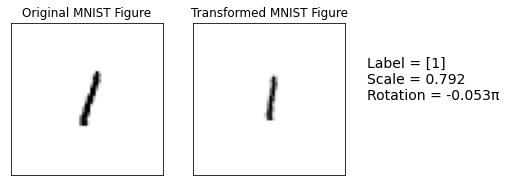

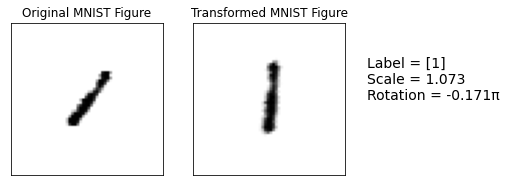

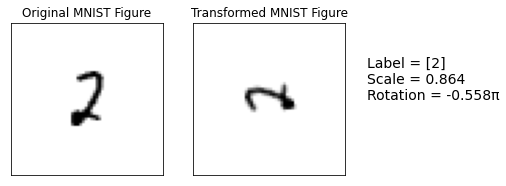

In [3]:
# Initialize and demonstrate dataloader

dtype = torch.FloatTensor

dataloader = Dataloader(image_path='../data/train-images.idx3-ubyte',
                        label_path='../data/train-labels.idx1-ubyte',
                        dtype=dtype)

or_img, trns_img, lbl, pose = dataloader.sample(100)
plot_example(or_img, trns_img, lbl, pose, number_examples=3)

In [4]:
# Load networks
autoenc = autoencoder.Autoencoder(dtype=dtype)
autoenc.load_state_dict(torch.load(class_autoencoder_path, map_location=torch.device('cpu')))
autoenc.eval()

cls_trns_model = class_transition_model.TransitionModel(dtype=dtype)
cls_trns_model.load_state_dict(torch.load(class_transition_model_path, map_location=torch.device('cpu')))
cls_trns_model.eval()

print('Loaded networks on device', dtype)

Loaded networks on device <class 'torch.FloatTensor'>


In [5]:
# Model Implementation
class CogOffloadingModel:
    def __init__(self, autoencoder, transition_model,
                 iterations=100, number_actions=100):
        self.iterations = iterations
        self.step = 0.2

        self.plot_iter = 0

        self.sigma_x = 10 # inverse precision of x
        self.h = torch.zeros(size=[1, 32])
        self.v = torch.ones(size=[10])/10
        self.c = torch.ones(size=[10])/10
        self.obs_x = torch.zeros(size=[1, 1, 56, 56])
        self.pred_x = torch.zeros(size=[1, 1, 56,56])

        self.obs_x_action = torch.zeros(size=[1, 1, 56, 56])
        self.c_final = torch.zeros(size=[10])
        self.text = ''

        self.h_record = None

        autoencoder.eval()
        self.decoder = autoencoder.decoder

        transition_model.eval()
        self.transition_model = transition_model

        self.number_actions = number_actions
        self.actions = np.zeros(shape=[self.number_actions, 2])
        self.g = np.zeros(shape=[self.number_actions])

        self.prior = None

        plotting
        self.fig = plt.figure(constrained_layout=True, figsize=(12, 6))
        gs = self.fig.add_gridspec(2, 4)

        self.axs_obs_x = self.fig.add_subplot(gs[0, 0], adjustable='box')
        self.axs_pred_x = self.fig.add_subplot(gs[0, 1], adjustable='box')
        self.axs_h = self.fig.add_subplot(gs[1, 0:2])
        self.axs_actions = self.fig.add_subplot(gs[1, 2], adjustable='box')
        self.axs_obs_x_action = self.fig.add_subplot(gs[0, 2], adjustable='box')
        self.axs_text = self.fig.add_subplot(gs[0, 3])
        self.axs_final_c = self.fig.add_subplot(gs[1, 3], adjustable='box')

        self.fig.suptitle('Cognitive Offloading Model', fontsize=20)

    def update_plot(self):
        self.axs_obs_x.clear()
        self.axs_obs_x.imshow(to_image(self.obs_x), cmap=cm.gray_r)
        self.axs_obs_x.set_xticks([])
        self.axs_obs_x.set_yticks([])
        self.axs_obs_x.set_title('Observed Image')

        self.axs_obs_x_action.clear()
        self.axs_obs_x_action.imshow(to_image(self.obs_x_action), cmap=cm.gray_r)
        self.axs_obs_x_action.set_xticks([])
        self.axs_obs_x_action.set_yticks([])
        self.axs_obs_x_action.set_title('After Action')

        self.axs_pred_x.clear()
        self.axs_pred_x.imshow(to_image(self.pred_x), cmap=cm.gray_r)
        self.axs_pred_x.set_xticks([])
        self.axs_pred_x.set_yticks([])
        self.axs_pred_x.set_title('Image predicted by latent states')

        if torch.equal(self.obs_x_action, torch.zeros(size=[1, 1, 56, 56])):
            xt, xf = 0.275, 0.225
        else:
            xt, xf = 0.475, 0.525

        arrow = mpatches.FancyArrowPatch((xt, 0.70), (xf, 0.70),
                                         arrowstyle='simple', fc='k',
                                         transform=self.fig.transFigure,
                                         mutation_scale=30)
        self.fig.patches = [arrow]

        self.axs_text.clear()
        self.axs_text.axis('off')
        self.axs_text.annotate(self.text, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=16)

        self.axs_final_c.clear()
        self.axs_final_c.bar(range(self.c_final.size(-1)), torch.squeeze(self.c_final).detach().numpy(), zorder=2, color='green', label='distribution')
        self.axs_final_c.bar(np.argmax(torch.squeeze(self.c_final).detach().numpy()), 1, zorder=0, color='lightgrey', label='final classification')
        self.axs_final_c.set_xticks(range(self.c_final.size(-1)))
        self.axs_final_c.set_ylim(0, 1)
        self.axs_final_c.set_title('Final classification')

        if self.prior is not None:
            self.axs_final_c.bar(range(self.prior.size(-1)), torch.squeeze(self.prior).numpy(), zorder=1, color='blue', alpha=0.5, label='prior')

        self.axs_final_c.legend()

        self.axs_h.clear()
        self.axs_h.plot(self.h_record)
        self.axs_h.set_title('Latent state transition')
        self.axs_h.set_xlabel('Iteration')

        self.axs_actions.clear()
        self.axs_actions.scatter(self.actions[:,0], self.actions[:,1], c=self.g, cmap=cm.viridis_r)
        self.axs_actions.plot(1, 0, 'rx')
        self.axs_actions.set_xlim([1 - 4*0.3, 1 + 4*0.3])
        self.axs_actions.set_ylim([-4*math.pi/1.5, 4*math.pi/1.5])
        self.axs_actions.set_xlabel('Scale')
        self.axs_actions.set_ylabel('Rotation')
        self.axs_actions.set_title('Sampled Actions')

        display.display(plt.gcf())
        plt.savefig(f'animation/plt{self.plot_iter}.png', transparent=False)
        self.plot_iter += 1
        display.clear_output(wait=True)

    def initialize_latent(self):
        self.h = torch.randn(size=self.h.size())
        self.h_record = torch.squeeze(self.h)

    def get_int_image(self):
        return self.pred_x

    def set_obs_image(self, img):
        self.obs_x = normalize_image(img)

    def update_c(self, v, alpha=10):
        self.v = torch.add(self.c, v, alpha=alpha)
        self.c = func.softmax(self.v, dim=1)

    def update_latent(self):
        var_h = Variable(self.h, requires_grad=True)
        var_h.grad = torch.zeros(var_h.size())

        self.pred_x = self.decoder(var_h)

        if torch.equal(self.obs_x_action, torch.zeros(size=[1, 1, 56, 56])):
            image = self.obs_x
        else:
            image = self.obs_x_action

        error = (1/self.sigma_x) * (image - self.pred_x)

        self.pred_x.backward(torch.ones(self.pred_x.shape)*error, retain_graph=True)

        return var_h.grad


    def infer_int_state(self):
        self.initialize_latent()
        self.h_record = torch.squeeze(self.h)
        for i in range(self.iterations):
            h_dot = self.update_latent()
            self.h = torch.add(self.h, h_dot, alpha=self.step)
            self.pred_x = self.decoder(self.h)

            # visualisation/debugging
            self.h_record = np.vstack([self.h_record, torch.squeeze(self.h)])
            if i % 10 == 0:
                self.update_plot()
                pass

        v = self.transition_model.classifier(self.pred_x)
        self.update_c(v)

    def set_prior(self, prior):
        self.prior = torch.reshape(prior, [1, 10])

    def sample_actions(self, m_scale=1, std_scale=0.25, m_rotation=0, std_rotation=math.pi/2):
        scales = np.random.normal(m_scale, std_scale, self.number_actions)
        rotations = np.random.normal(m_rotation, std_rotation, self.number_actions)
        self.actions = np.stack([scales, rotations], axis=1)

        for i in range(self.number_actions):
            new_c = torch.squeeze(self.transition_model(self.pred_x, self.actions[i])).detach().numpy()

            old_c = torch.squeeze(self.c).detach().numpy()

            self.g[i] = self.expected_free_energy(old_c, new_c, self.prior)

    def expected_free_energy(self, old_states, new_states, prior=None):
        if prior is None:
            return -np.dot(new_states, np.log(new_states/old_states))
        else:
            prior = torch.squeeze(prior).detach().numpy()
            return np.dot(new_states, np.log(old_states/prior))

    def do_action(self):
        self.sample_actions()
        action = self.actions[np.argmin(self.g)]
        self.obs_x_action = transform_image(self.obs_x, torch.Tensor(action))
        self.text = f'scaled by {action[0]:.3f}\nrotated by {action[1]/math.pi:.3f}π\n\n'
        self.update_plot()
        return action

    def classify(self):
        self.c_final = self.transition_model.classifier(self.pred_x)
        cls = np.argmax(torch.squeeze(self.c_final).detach().numpy())
        self.text += f'classified as {cls}'
        self.update_plot()
        return cls

In [6]:
n = 7

index = 0
for i in range(len(lbl)):
    if lbl[i, n] == 1:
        index = i
        break

In [7]:
p = 4

image = trns_img[index]

prior = to_distribution([p], dims=10)
prior = torch.softmax( torch.add(prior, 5), dim=1)

model = CogOffloadingModel(autoenc, cls_trns_model,
                           iterations=200, number_actions=200)
model.set_obs_image(image)

model.set_prior(prior)
model.infer_int_state()
a = model.do_action()
model.infer_int_state()
c = model.classify()

# Quantitative Tests

Comment out plotting parts of model when running this.

In [8]:
iterations = np.arange(50, 300, 25)
sampled_actions = np.arange(50, 300, 25)

err_class = np.zeros(shape=[len(iterations), len(sampled_actions)])

for i, iter in enumerate(iterations):
    for j, act in enumerate(sampled_actions):
        N = len(trns_img)
        print(f'Running {N} tests with iterations = {iter} and actions = {act}', end='')

        classification = np.zeros(shape=N)
        scale_off = np.zeros(shape=N)
        rotation_off = np.zeros(shape=N)

        for n in range(N):
            model = CogOffloadingModel(autoenc, cls_trns_model,
                                       iterations=iter, number_actions=act)
            model.set_obs_image(trns_img[n])

            # run model
            model.infer_int_state()
            a = model.do_action()
            model.infer_int_state()
            c = model.classify()

            # evaluate
            classification[n] = int(c != np.argmax(lbl[n]))

        err_class[i, j] = np.mean(classification)
        print(f' - finished!\n    avg. error = {err_class[i, j]:.3f}')

np.savetxt("./quant_results/err_class.csv", err_class, delimiter=",")
print('Done.')

Running 100 tests with iterations = 50 and actions = 50 - finished!
    avg. error = 0.810
Running 100 tests with iterations = 50 and actions = 75 - finished!
    avg. error = 0.770
Running 100 tests with iterations = 50 and actions = 100 - finished!
    avg. error = 0.720
Running 100 tests with iterations = 50 and actions = 125 - finished!
    avg. error = 0.840
Running 100 tests with iterations = 50 and actions = 150 - finished!
    avg. error = 0.790
Running 100 tests with iterations = 50 and actions = 175 - finished!
    avg. error = 0.790
Running 100 tests with iterations = 50 and actions = 200 - finished!
    avg. error = 0.820
Running 100 tests with iterations = 50 and actions = 225 - finished!
    avg. error = 0.800
Running 100 tests with iterations = 50 and actions = 250 - finished!
    avg. error = 0.770
Running 100 tests with iterations = 50 and actions = 275 - finished!
    avg. error = 0.750
Running 100 tests with iterations = 75 and actions = 50 - finished!
    avg. error

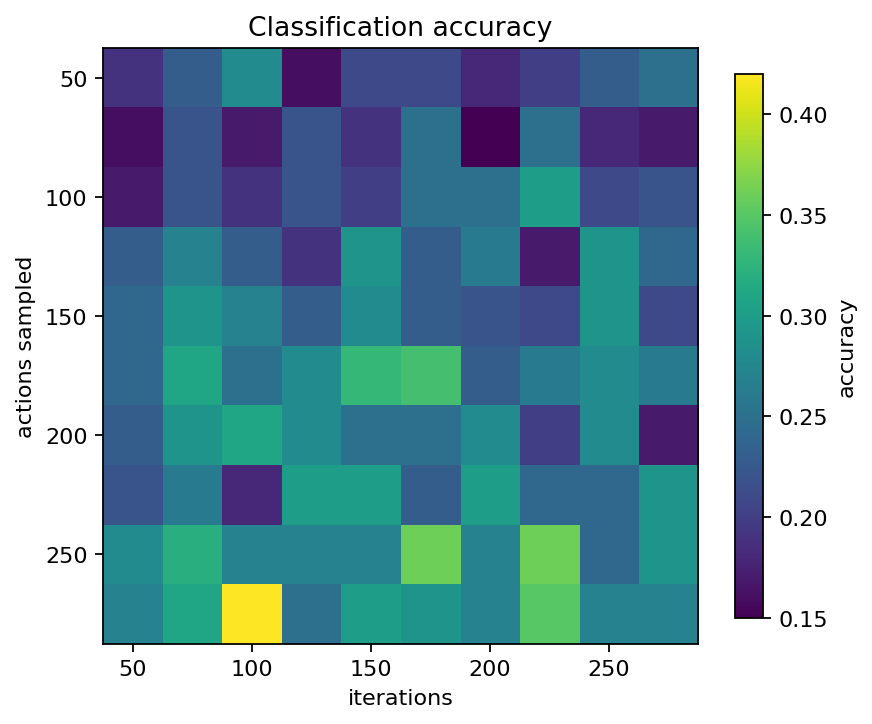

In [52]:
if err_class is None:
    err_class = np.genfromtxt("./quant_results/err_class.csv", delimiter=',')

acc = 1 - err_class

fig, ax = plt.subplots(1, 1, figsize=(6,6), dpi=160)
mat = ax.matshow(acc)

ax.set_xticks(np.arange(0, 10, 2))
ax.set_xticklabels(np.arange(50, 300, 50))
ax.set_xlabel('iterations')
ax.xaxis.tick_bottom()

ax.set_yticks(np.arange(0, 10, 2))
ax.set_yticklabels(np.arange(50, 300, 50))
ax.set_ylabel('actions sampled')

fig.colorbar(mat, ax=ax, shrink=0.75, label='accuracy')

ax.set_title('Classification accuracy')
plt.show()